# 2.4 データのクリーニング

RによるサンプルコードはBookRepoにある

https://github.com/PracticalTimeSeriesAnalysis/BookRepo/blob/master/Ch02/missing.R


In [1]:
require(zoo)
require(data.table)

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: data.table



## 欠損値

米国政府作成の月次失業率データをベースに、欠損データを作成する。

2種類の欠損データを作成する。

1. 無作為にデータが欠損
1. 最も失業率の高い幾つかの月のデータを欠損（系統的な欠損値）

欠損値を埋めるための方法として、以下の3つを見ていく

1. 前方埋め
1. 移動平均
1. 補間

In [2]:
unemp <- fread("data/UNRATE.csv")
unemp[, DATE := as.Date(DATE)]
setkey(unemp, DATE)

In [3]:
unemp[1:5,]

DATE,UNRATE
<date>,<dbl>
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


欠損データを作っている。
欠損データは2種類。

In [4]:
## generate a data set where data is randomly missing　無作為欠損
rand.unemp.idx <- sample(1:nrow(unemp), .1*nrow(unemp))
rand.unemp <- unemp[-rand.unemp.idx]

In [5]:
## generate a data set where data is more likely to be missing if it's high
## 系統的な欠損
high.unemp.idx <- which(unemp$UNRATE > 8)
high.unemp.idx <- sample(high.unemp.idx, .5 * length(high.unemp.idx))
bias.unemp <- unemp[-high.unemp.idx]

タイムスタンプが飛んでいるので、欠損箇所にNAを加えて、完全な時系列データにする。

In [6]:
all.dates <- seq(from = unemp$DATE[1], to = tail(unemp$DATE, 1), by = "months")

rand.unemp = rand.unemp[J(all.dates), roll=0]
bias.unemp = bias.unemp[J(all.dates), roll=0]

rand.unemp[, rpt := is.na(UNRATE)] # 欠損しているレコードを示すフラグ

In [7]:
rand.unemp[1:5,]

DATE,UNRATE,rpt
<date>,<dbl>,<lgl>
1948-01-01,3.4,FALSE
1948-02-01,3.8,FALSE
1948-03-01,4.0,FALSE
1948-04-01,3.9,FALSE
1948-05-01,3.5,FALSE


### 前方埋め

直前の測定点を信頼する方法。

In [8]:
rand.unemp[, impute.ff := na.locf(UNRATE, na.rm = FALSE)]
bias.unemp[, impute.ff := na.locf(UNRATE, na.rm = FALSE)]

In [9]:
rand.unemp[1:5,]

DATE,UNRATE,rpt,impute.ff
<date>,<dbl>,<lgl>,<dbl>
1948-01-01,3.4,FALSE,3.4
1948-02-01,3.8,FALSE,3.8
1948-03-01,4.0,FALSE,4.0
1948-04-01,3.9,FALSE,3.9
1948-05-01,3.5,FALSE,3.5


前方埋めの結果を可視化。ほとんどは欠損していないので、真値と重なっている。大きな違和感ない。

NULL

NULL

NULL

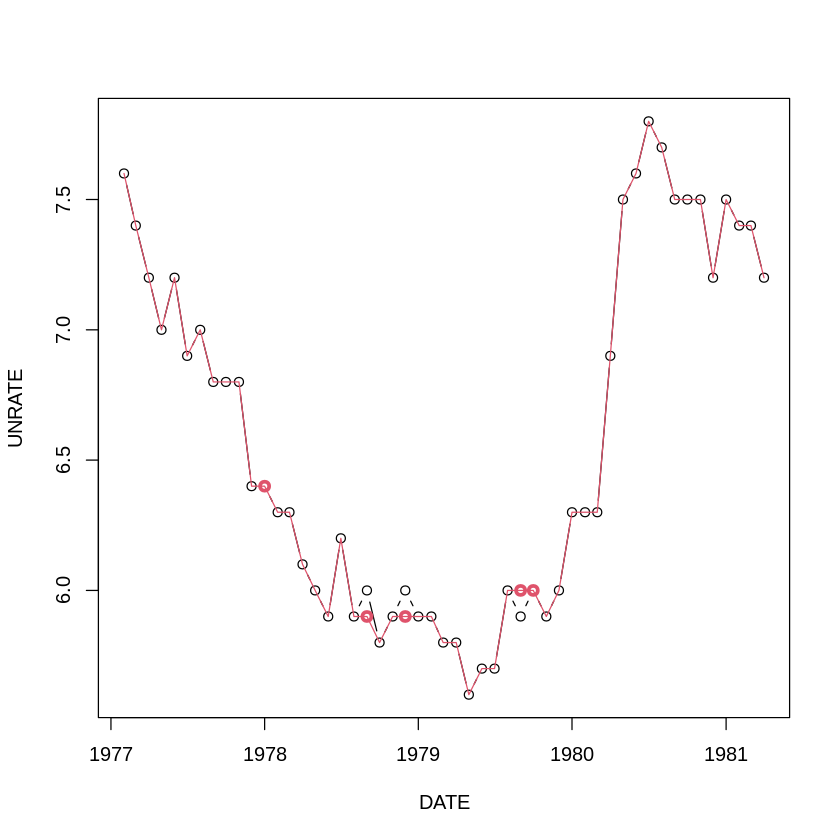

In [10]:
#png("ffplot.png")
unemp[350:400, plot(DATE, UNRATE, col = 1, type = 'b')]
rand.unemp[350:400, lines(DATE, impute.ff, col = 2)]
rand.unemp[350:400][rpt == TRUE, points(DATE, impute.ff, col = 2, lwd = 3)]
#dev.off()

黒線が真値。赤線が補完した結果。

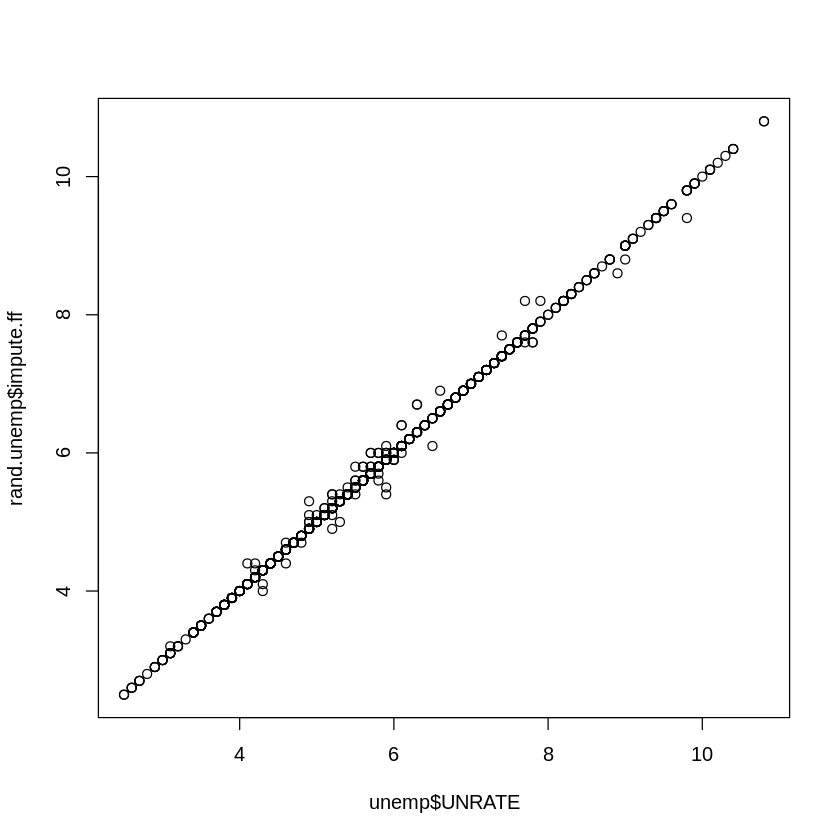

In [11]:
plot(unemp$UNRATE, rand.unemp$impute.ff)

### 移動平均

ノイズが多い環境では、前の測定値を信頼するよりも、平均を使った方が良い。

移動平均を取る場合は、時間的に先のデータを使って良いかは良く検討が必要。
目的によっては先のデータを使っても良いことがある。（系列データの分類をしたいとかそういうとき？）

In [12]:
# 先読みがない、前の状態だけを利用した移動平均
rand.unemp[, impute.rm.nolookahead := rollapply(c(NA, NA, UNRATE), 3,
             function(x) {
                         if (!is.na(x[3])) x[3] else mean(x, na.rm = TRUE)
                         })]         
bias.unemp[, impute.rm.nolookahead := rollapply(c(NA, NA, UNRATE), 3,
             function(x) {
                         if (!is.na(x[3])) x[3] else mean(x, na.rm = TRUE)
                         })]

In [13]:
# 先読みのある、前後で平均をとる
rand.unemp[, impute.rm.lookahead := rollapply(c(NA, UNRATE, NA), 3,
             function(x) {
                         if (!is.na(x[2])) x[2] else mean(x, na.rm = TRUE)
                         })]         
bias.unemp[, impute.rm.lookahead := rollapply(c(NA, UNRATE, NA), 3,
             function(x) {
                         if (!is.na(x[2])) x[2] else mean(x, na.rm = TRUE)
                         })]

In [14]:
rand.unemp[1:5,]

DATE,UNRATE,rpt,impute.ff,impute.rm.nolookahead,impute.rm.lookahead
<date>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
1948-01-01,3.4,FALSE,3.4,3.4,3.4
1948-02-01,3.8,FALSE,3.8,3.8,3.8
1948-03-01,4.0,FALSE,4.0,4.0,4.0
1948-04-01,3.9,FALSE,3.9,3.9,3.9
1948-05-01,3.5,FALSE,3.5,3.5,3.5


NULL

NULL

NULL

NULL

NULL

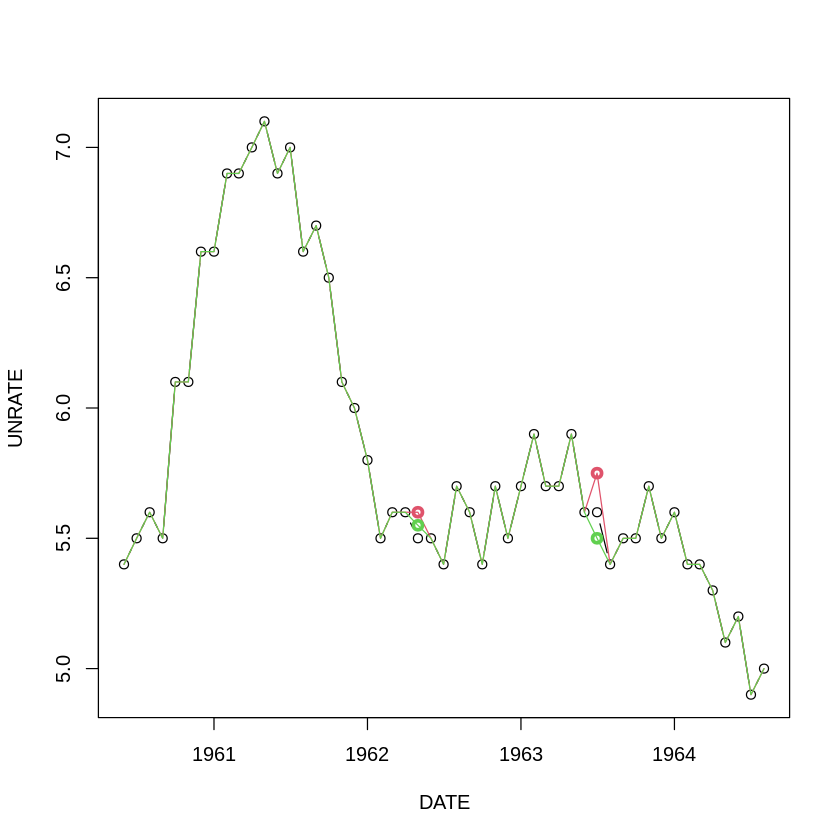

In [15]:
#png("maplot.png")
use.idx = 150:200
unemp[use.idx, plot(DATE, UNRATE, col = 1, type = 'b')]
rand.unemp[use.idx, lines(DATE, impute.rm.nolookahead, col = 2)]
rand.unemp[use.idx][rpt == TRUE, points(DATE, impute.rm.nolookahead, col = 2, lwd = 3)]
rand.unemp[use.idx, lines(DATE, impute.rm.lookahead, col = 3)]
rand.unemp[use.idx][rpt == TRUE, points(DATE, impute.rm.lookahead, col = 3, lwd = 3)]
#dev.off()

赤線が先読みなしの移動平均補間。緑線が先読みのある移動平均補間。

黒は設定値。

### 補間

線形補間：線形性を仮定して、直前のデータから線形関数を使って欠損値を回帰する

ここでは、二つの線形補間を試行

1. 直線補間
1. 多項式補間

線形補間は、データ構造として線形性を仮定できる場合に適用できる（トレンドを持つ）。
例えば、成長している事業の販売データなどは線形的に増加しているトレンドを加味して補間できる。

一方、降水データなどは、線形的なトレンドを仮定できない。

In [16]:
## linear interpolation
rand.unemp[, impute.li := na.approx(UNRATE)]
bias.unemp[, impute.li := na.approx(UNRATE)]

## polynomial interpolation
rand.unemp[, impute.sp := na.spline(UNRATE)]
bias.unemp[, impute.sp := na.spline(UNRATE)]

NULL

NULL

NULL

NULL

NULL

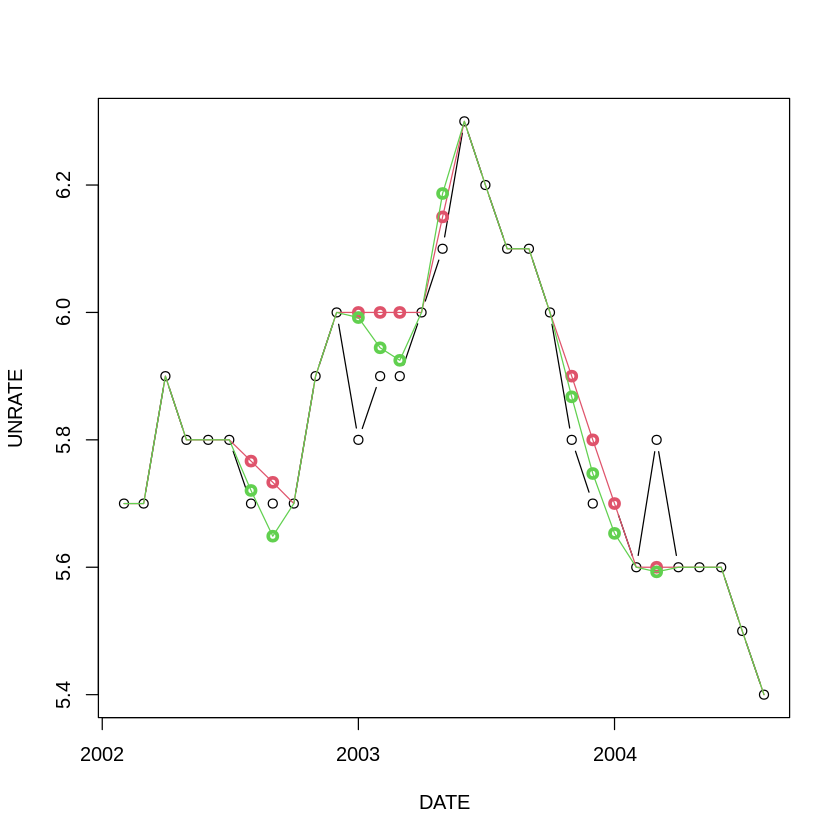

In [17]:
#png("splineplot.png")
use.idx = 650:680
unemp[use.idx, plot(DATE, UNRATE, col = 1, type = 'b')]
rand.unemp[use.idx, lines(DATE, impute.li, col = 2)]
rand.unemp[use.idx][rpt == TRUE, points(DATE, impute.li, col = 2, lwd = 3)]
rand.unemp[use.idx, lines(DATE, impute.sp, col = 3)]
rand.unemp[use.idx][rpt == TRUE, points(DATE, impute.sp, col = 3, lwd = 3)]
#dev.off()

赤線が線形補間。緑線が多項式補間。


### 欠損値補間の比較

平均二乗誤差の比較。

先読みを含めているかを注意。

以下はランダムに欠損がある場合の補完結果の比較。先読みしていれば、誤差は低い（当然）。

このデータでは線形補間の誤差が少ないようだ。ただし、データの先読みをしている。

- `ff`: 前方補完
- `rm.nolookahead`: 移動平均（先読みなし）
- `rm.lookahead`: 移動平均（先読みあり）
- `li`: 線形補間
- `sp`: 多項式補間

In [18]:
sort(rand.unemp[ , lapply(.SD, function(x) mean((x - unemp$UNRATE)^2, na.rm = TRUE)),
             .SDcols = c("impute.ff", "impute.rm.nolookahead", "impute.rm.lookahead", "impute.li", "impute.sp")])

Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”


impute.li,impute.sp,impute.rm.lookahead,impute.ff,impute.rm.nolookahead
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.001384939,0.001604029,0.001828979,0.004146919,0.005044537


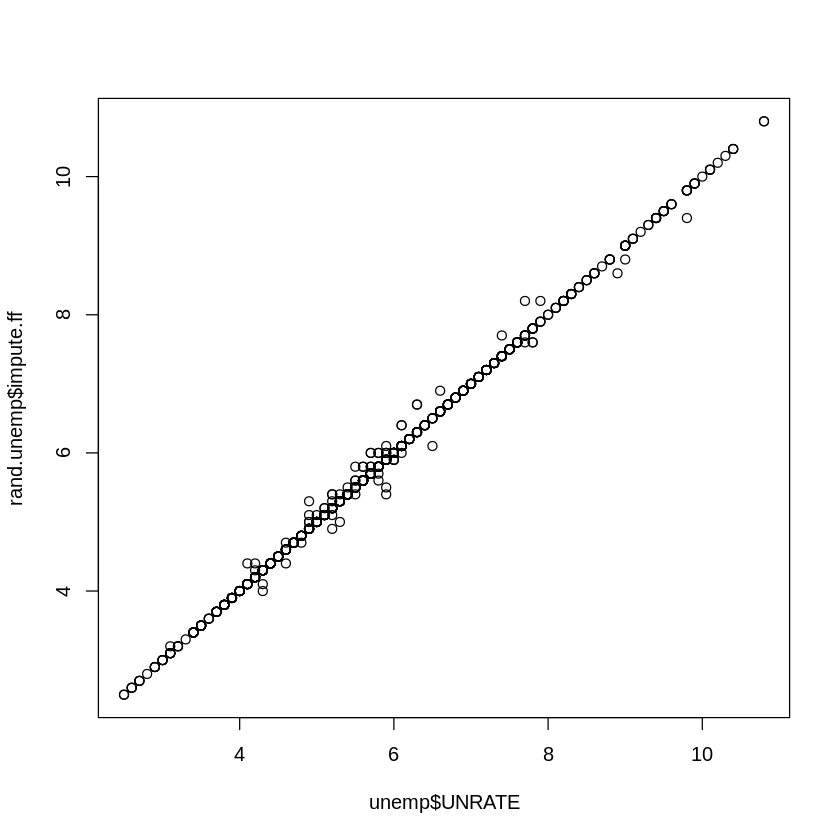

In [19]:
plot(unemp$UNRATE, rand.unemp$impute.ff)

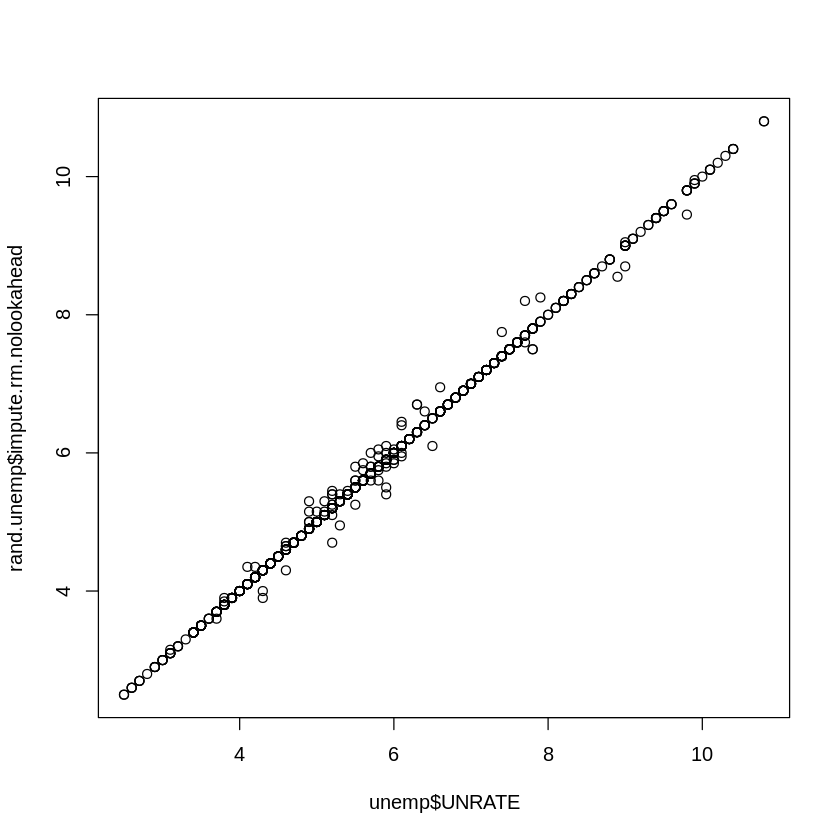

In [20]:
plot(unemp$UNRATE, rand.unemp$impute.rm.nolookahead)

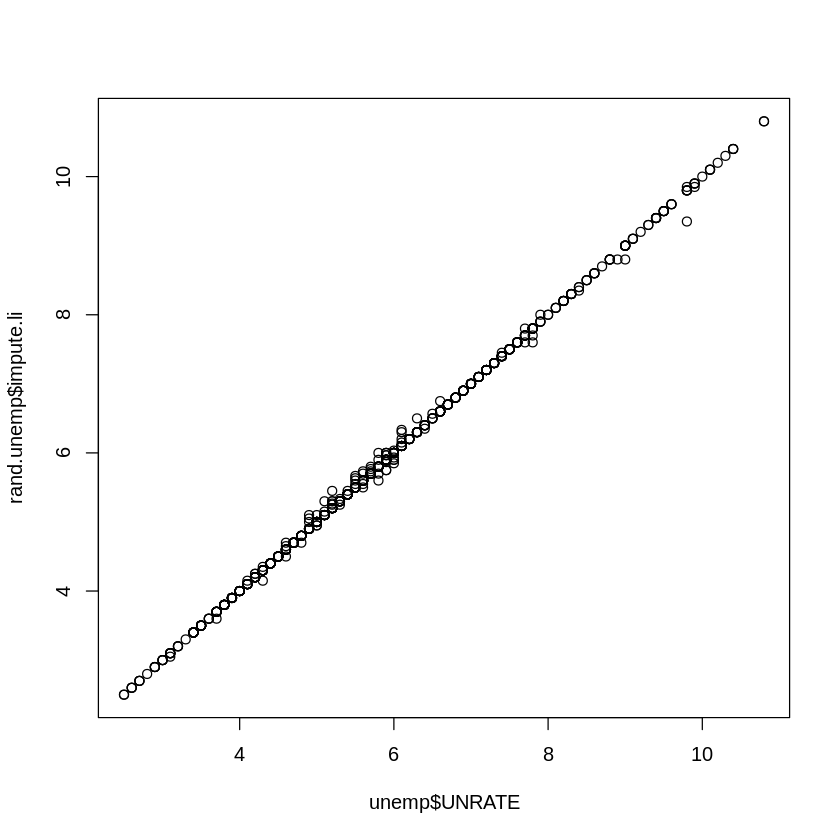

In [21]:
plot(unemp$UNRATE, rand.unemp$impute.li)

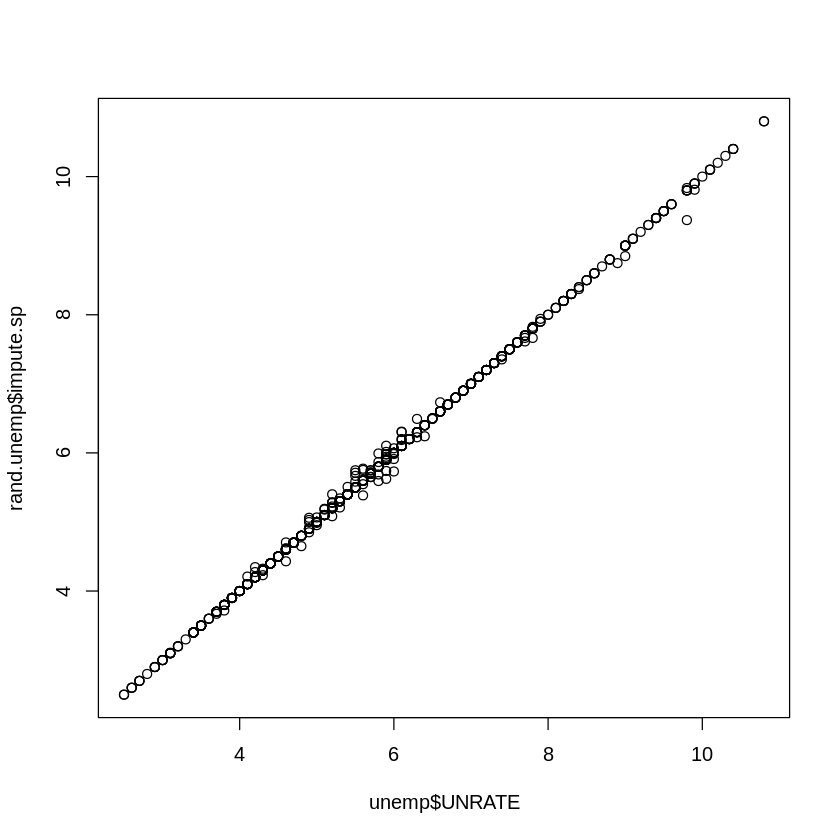

In [22]:
plot(unemp$UNRATE, rand.unemp$impute.sp)

以下は系統的に欠損がある場合の補完結果の比較。先読みしていれば、誤差は低い（当然）。

このデータでも線形補間の誤差が少ないようだ。ただし、データの先読みをしている。

- `ff`: 前方補完
- `rm.nolookahead`: 移動平均（先読みなし）
- `rm.lookahead`: 移動平均（先読みあり）
- `li`: 線形補間
- `sp`: 多項式補間

In [23]:
sort(bias.unemp[ , lapply(.SD, function(x) mean((x - unemp$UNRATE)^2, na.rm = TRUE)),
             .SDcols = c("impute.ff", "impute.rm.nolookahead", "impute.rm.lookahead", "impute.li", "impute.sp")])

Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”


impute.rm.lookahead,impute.li,impute.sp,impute.rm.nolookahead,impute.ff
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.0008973589,0.00112263,0.001188336,0.001872749,0.00242891


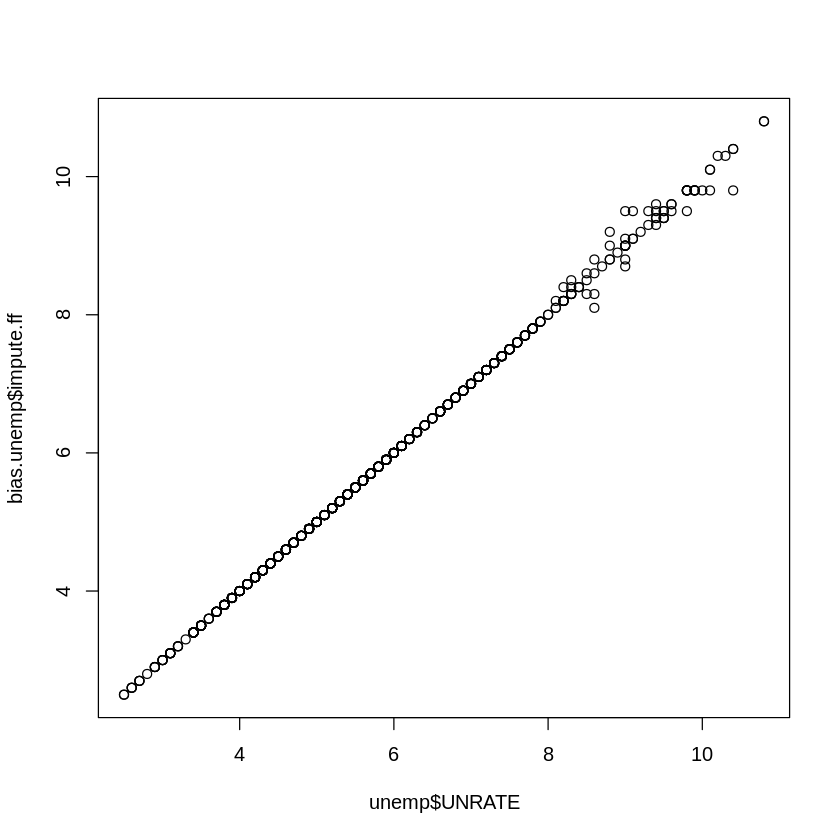

In [24]:
plot(unemp$UNRATE, bias.unemp$impute.ff)

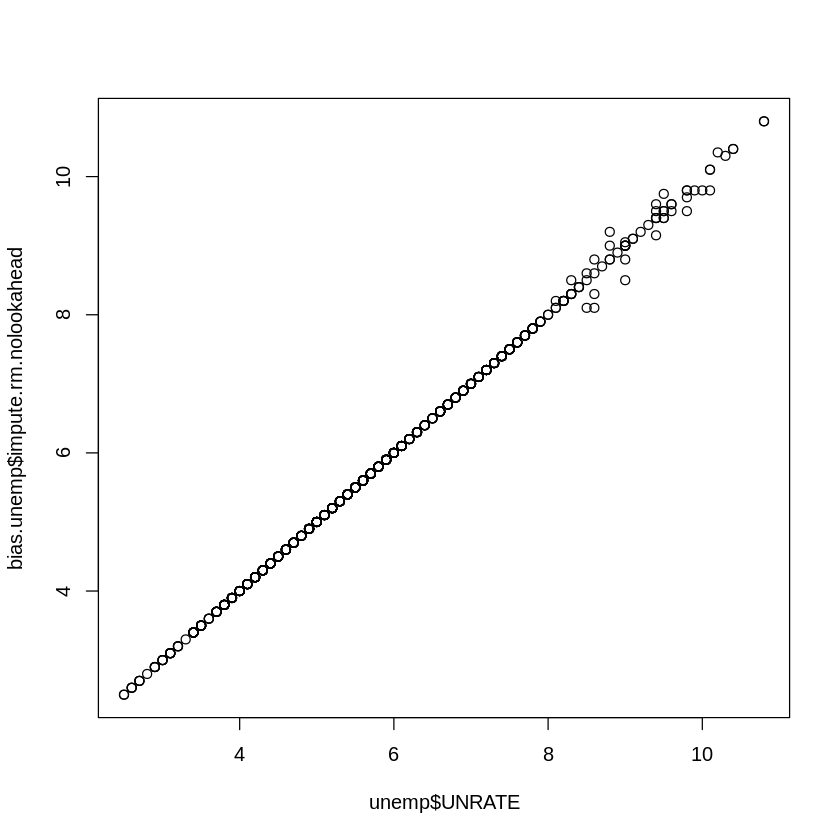

In [25]:
plot(unemp$UNRATE, bias.unemp$impute.rm.nolookahead)

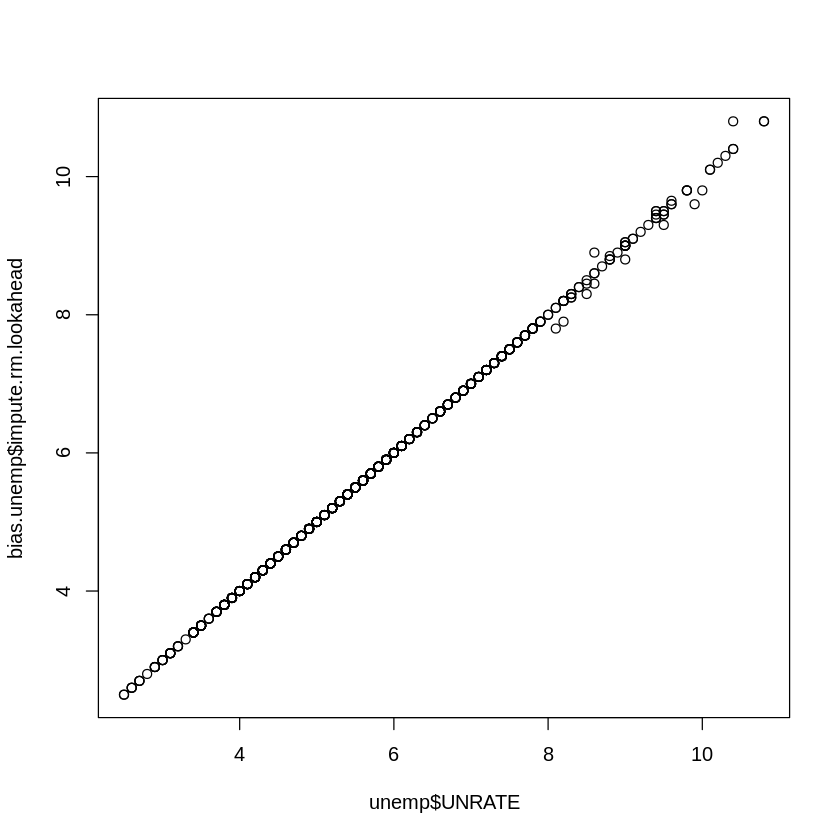

In [26]:
plot(unemp$UNRATE, bias.unemp$impute.rm.lookahead)

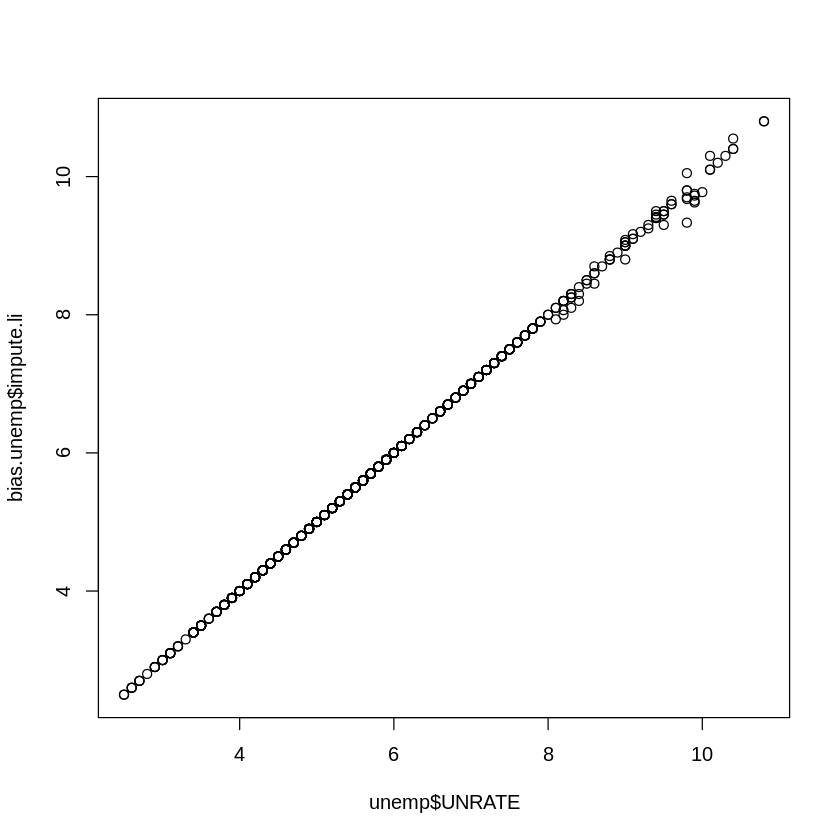

In [27]:
plot(unemp$UNRATE, bias.unemp$impute.li)

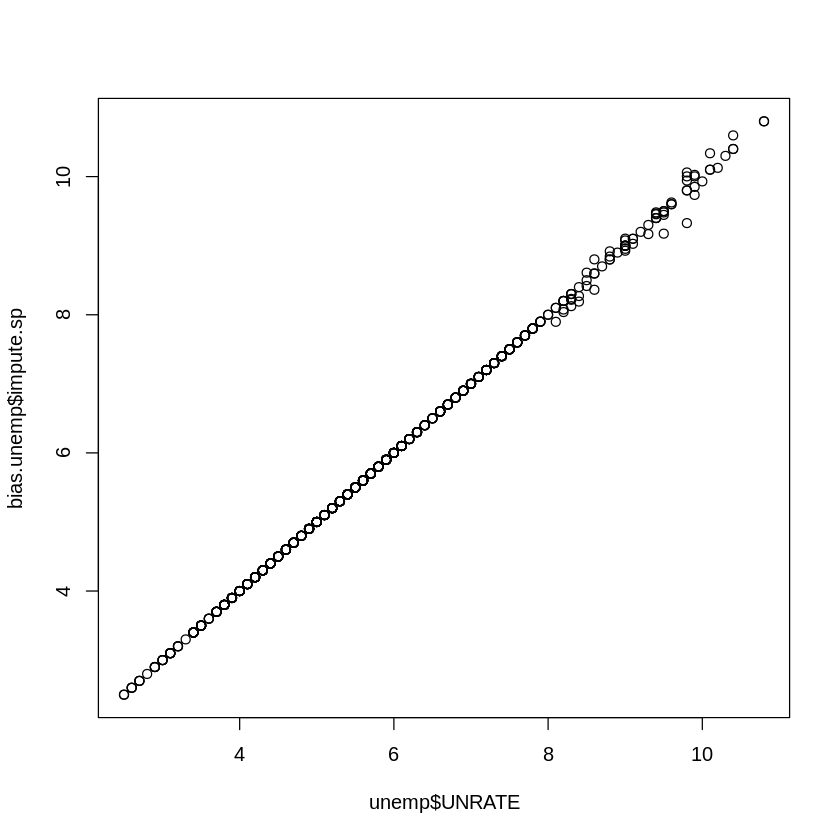

In [28]:
plot(unemp$UNRATE, bias.unemp$impute.sp)